In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./test_score.ipynb'))))

import numpy as np
import pandas as pd

from ylearn.estimator_model.causal_forest import CausalForest
from ylearn.estimator_model._generalized_forest._grf import GRForest
from ylearn.exp_dataset.exp_data import sq_data
from ylearn.utils._common import to_df
from ylearn.estimator_model._naive_forest.utils import grad, grad_coef, inverse_grad

from numpy.linalg import lstsq, inv

from copy import deepcopy


n = 2000
d = 10     
n_x = 1
y, x, v = sq_data(n, d, n_x)

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])
w = deepcopy(v)
v_test = v[:min(100, n)].copy()
v_test[:, 0] = np.linspace(np.percentile(v[:, 0], 1), np.percentile(v[:, 0], 99), min(100, n))
data = to_df(treatment=x, outcome=y, v=v)
test_data = to_df(v=v_test)

outcome = 'outcome'
treatment = 'treatment'
adjustment = data.columns[2:]
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
# x = oh.fit_transform(x).toarray().astype(np.float32)

10-12 15:05:25 I ylearn.e.double_ml.py 747 - _fit_1st_stage: fitting x_model RandomForestRegressor
10-12 15:05:26 I ylearn.e.double_ml.py 752 - _fit_1st_stage: fitting y_model RandomForestRegressor


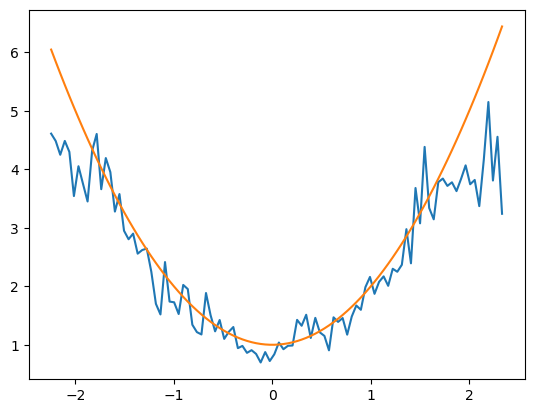

In [5]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV


cf = CausalForest(
    # x_model=RandomForestClassifier(),
    # x_model=LogisticRegressionCV(),
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=1,
    is_discrete_treatment=False,
    n_jobs=1,
    n_estimators=100,
    random_state=3,
    min_samples_split=10,
    min_samples_leaf=3,
    min_impurity_decrease=1e-10,
    max_depth=100,
    max_leaf_nodes=1000,
    sub_sample_num=0.45,
    verbose=0,
    honest_subsample_num=None,
)
cf.fit(data=data, outcome=outcome, treatment=treatment, adjustment=None, covariate=adjustment)
effect = cf.estimate(test_data)
import matplotlib.pyplot as plt

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])

for t in range(n_x):
    plt.plot(v_test[:, 0], effect[:, t])
    # plt.plot(v_test[:, 0], ef[:, t])
    # plt.plot(v_test[:, 0], effect__[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()

10-12 15:06:54 I ylearn.e.double_ml.py 747 - _fit_1st_stage: fitting x_model RandomForestRegressor
10-12 15:06:56 I ylearn.e.double_ml.py 752 - _fit_1st_stage: fitting y_model RandomForestRegressor


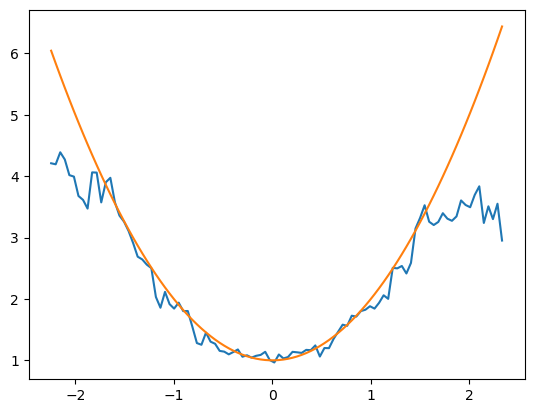

In [11]:
cf_honest = CausalForest(
    # x_model=RandomForestClassifier(),
    # x_model=LogisticRegressionCV(),
    x_model=RandomForestRegressor(),
    y_model=RandomForestRegressor(),
    cf_fold=1,
    is_discrete_treatment=False,
    n_jobs=1,
    n_estimators=100,
    random_state=2022,
    min_samples_split=20,
    min_samples_leaf=3,
    min_impurity_decrease=1e-10,
    max_depth=100,
    max_leaf_nodes=1000,
    sub_sample_num=0.8,
    verbose=0,
    honest_subsample_num=0.45,
)

cf_honest.fit(data=data, outcome=outcome, treatment=treatment, adjustment=None, covariate=adjustment)
effect_honest = cf_honest.estimate(test_data)
import matplotlib.pyplot as plt

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])

for t in range(n_x):
    plt.plot(v_test[:, 0], effect_honest[:, t])
    # plt.plot(v_test[:, 0], ef[:, t])
    # plt.plot(v_test[:, 0], effect__[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()